In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ]
)

# Load Training Dataset (Train 2012)
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=transform)

# Load Test Dataset (Val 2012, since VOC does not have a separate test set)
test_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

100%|██████████| 2.00G/2.00G [01:56<00:00, 17.2MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [43]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            DoubleConv(in_channels, 64),
            nn.MaxPool2d(2),
            DoubleConv(64, 128),
            nn.MaxPool2d(2),
            DoubleConv(128, 256),
            nn.MaxPool2d(2),
            DoubleConv(256, 512),
            nn.MaxPool2d(2),
            DoubleConv(512, 1024)
        )

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder[0](x)
        enc2 = self.encoder[2](self.encoder[1](enc1))
        enc3 = self.encoder[4](self.encoder[3](enc2))
        enc4 = self.encoder[6](self.encoder[5](enc3))
        bottleneck = self.encoder[8](self.encoder[7](enc4))

        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))

        return self.final_conv(dec1)


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
model = UNet(in_channels=3, out_channels=21).to(device)  # 21 classes for Pascal VOC

# Loss and Optimizer
weights = torch.tensor([0.4] + [1.0] * 20).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)  # Use CrossEntropyLoss for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)  # Convert masks to long type

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))  # Squeeze to match shape
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.8262
Epoch 2/5, Loss: 0.3595
Epoch 3/5, Loss: 0.3396
Epoch 4/5, Loss: 0.3351
Epoch 5/5, Loss: 0.3280


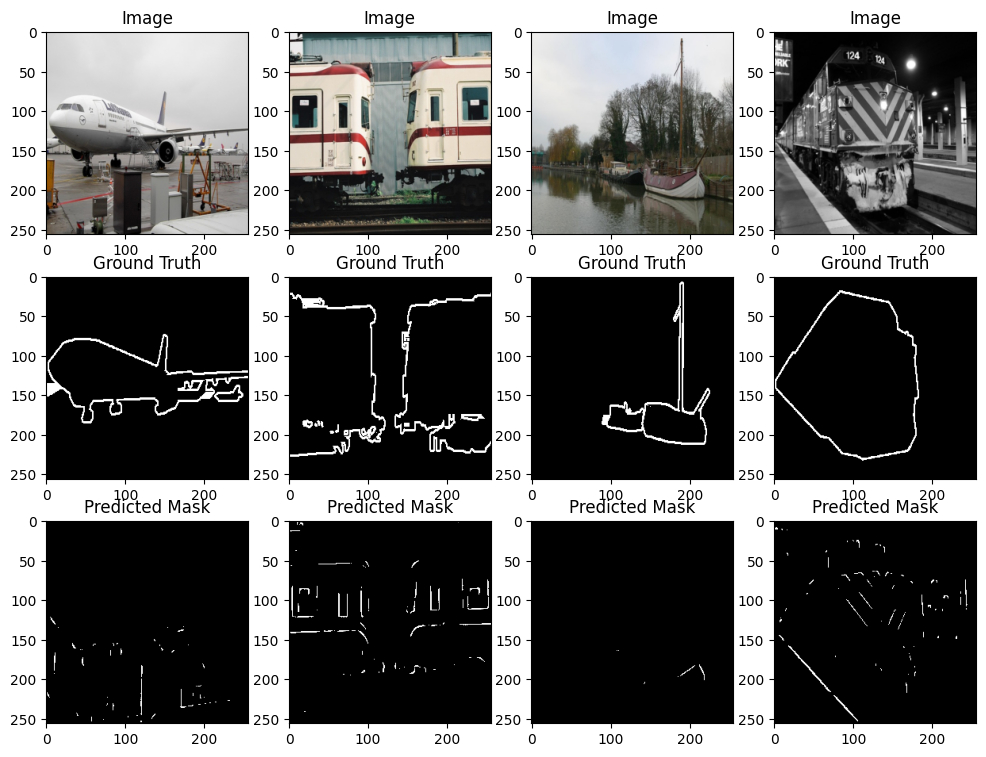

In [51]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device, dtype=torch.long)

    outputs = model(images)
    predicted_masks = torch.argmax(outputs, dim=1)

    # Convert to numpy for visualization
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    masks_np = masks.squeeze(1).cpu().numpy()
    preds_np = predicted_masks.cpu().numpy()

    # Plot sample image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):  # Show 4 samples
        axes[0, i].imshow(images_np[i])
        axes[0, i].set_title("Image")
        axes[1, i].imshow(masks_np[i], cmap="gray")
        axes[1, i].set_title("Ground Truth")
        axes[2, i].imshow(preds_np[i], cmap="gray")
        axes[2, i].set_title("Predicted Mask")
    plt.show()